In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from scipy.stats import uniform

In [2]:
df = pd.read_csv("data3.csv")
df

,p1,p2,p3,p4
0,3.745401,1.727030,9.723854,-0.699337
1,9.507143,2.966814,2.585795,-0.891283
2,7.319939,-2.495321,13.085918,-0.049140
3,5.986585,1.248741,9.196744,1.550008
4,1.560186,0.717460,2.358058,0.920662
...,...,...,...,...
2995,8.652958,1.844354,7.723942,0.053968
2996,1.572732,0.032204,2.480556,0.982780
2997,3.097879,2.651488,14.665692,-0.287439
2998,2.900455,-0.147094,1.618868,-0.224556


In [3]:
df.describe()

,p1,p2,p3,p4
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,4.998932,-0.056850,7.310881,-0.016117
std,2.916564,2.874237,4.283771,0.839563
min,0.000116,-4.999693,0.003615,-1.981106
25%,2.458056,-2.542724,3.622006,-0.673189
50%,5.053537,-0.119611,7.236875,0.016096
75%,7.543344,2.385903,10.930185,0.648512
max,9.997177,4.995577,14.991910,2.034798


In [4]:
x, y = df[["p1", "p2", "p3"]], df["p4"]

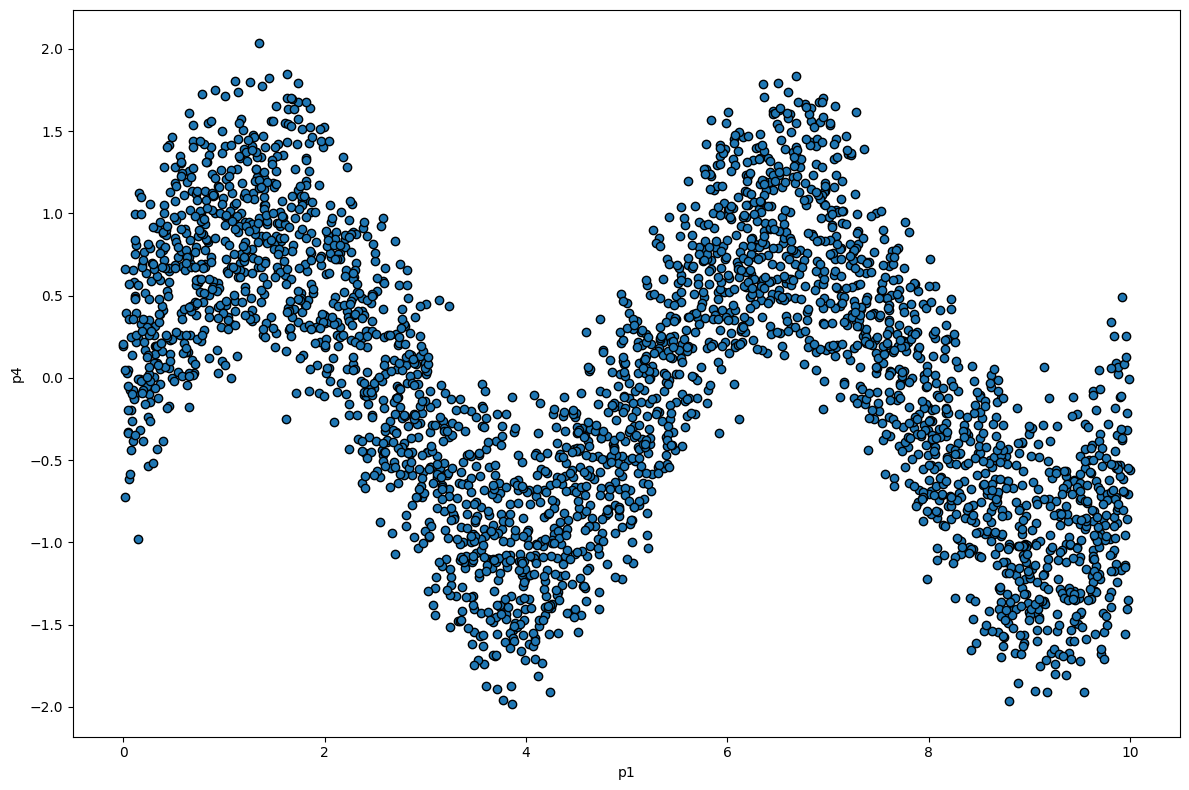

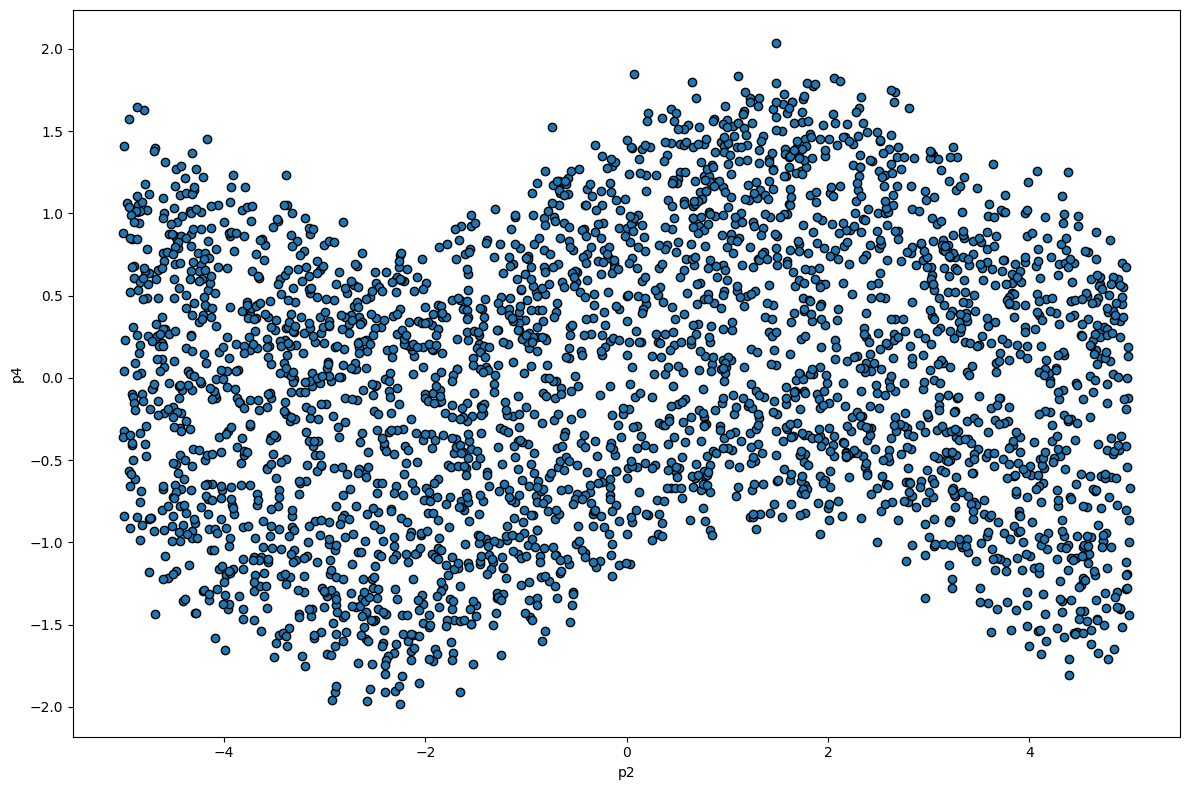

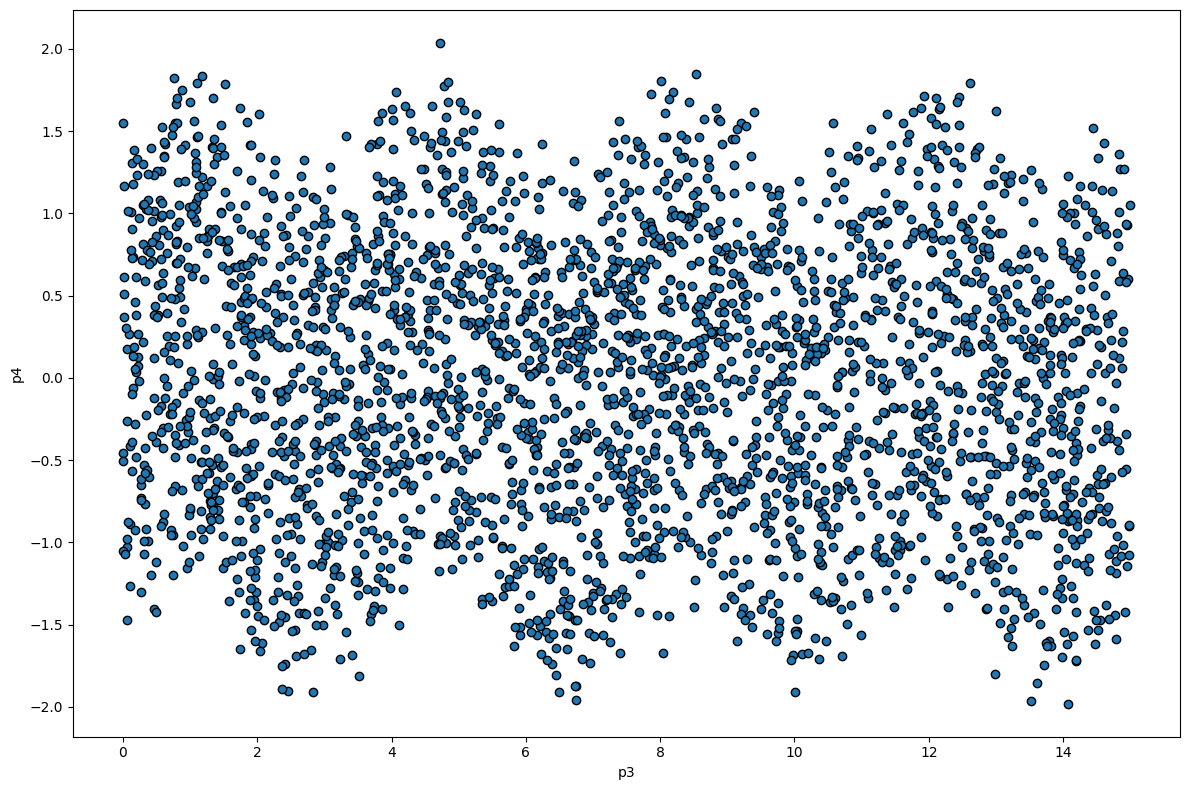

In [5]:
for p in x.columns:
	plt.figure(figsize=(12, 8))
	plt.scatter(df[p], y, ec="k")

	plt.xlabel(f"{p}")
	plt.ylabel("p4")

	plt.tight_layout()
	plt.show()

In [6]:
x

,p1,p2,p3
0,3.745401,1.727030,9.723854
1,9.507143,2.966814,2.585795
2,7.319939,-2.495321,13.085918
3,5.986585,1.248741,9.196744
4,1.560186,0.717460,2.358058
...,...,...,...
2995,8.652958,1.844354,7.723942
2996,1.572732,0.032204,2.480556
2997,3.097879,2.651488,14.665692
2998,2.900455,-0.147094,1.618868


In [7]:
norms = [StandardScaler(), MinMaxScaler()]
shifts = uniform(loc=y.min(), scale=y.max() * 2).rvs(1000)

shift_dict = {}
for norm in norms:
	pipeline = make_pipeline(
		norm,
		LinearRegression()
	)

	for col in ["p1", "p2", "p3"]:
		shift_dict[col] = {
			"sin": {
				"R2": [],
				"MSE": [],
				"MAE": [],
			},
			"cos": {
				"R2": [],
				"MSE": [],
				"MAE": [],
			},
		}

		for shift in shifts:
			result_sin = cross_validate(
				pipeline,
				np.column_stack([np.sin(x[col] * shift)]),
				y,
				scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
			)

			result_cos = cross_validate(
				pipeline,
				np.column_stack([np.cos(x[col] * shift)]),
				y,
				scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
			)

			shift_dict[col]["sin"]["R2"] += [[shift, result_sin["test_r2"].mean()]]
			shift_dict[col]["sin"]["MSE"] += [[shift, result_sin["test_neg_mean_squared_error"].mean()]]
			shift_dict[col]["sin"]["MAE"] += [[shift, result_sin["test_neg_mean_absolute_error"].mean()]]

			shift_dict[col]["cos"]["R2"] += [[shift, result_cos["test_r2"].mean()]]
			shift_dict[col]["cos"]["MSE"] += [[shift, result_cos["test_neg_mean_squared_error"].mean()]]
			shift_dict[col]["cos"]["MAE"] += [[shift, result_cos["test_neg_mean_absolute_error"].mean()]]

		for func in ["sin", "cos"]:
			for metric in ["R2", "MSE", "MAE"]:
				shift_dict[col][func][metric].sort(key=lambda x: x[1], reverse=True)
				shift_dict[col][func][metric] = shift_dict[col][func][metric][0]


shift_dict

{'p1': {'sin': {'R2': [np.float64(-1.199496612033173),
    np.float64(0.7379236699908515)],
   'MSE': [np.float64(-1.199496612033173), np.float64(-0.18410921694657298)],
   'MAE': [np.float64(-1.20440643251793), np.float64(-0.35543014907853615)]},
  'cos': {'R2': [np.float64(0.9612236179859719),
    np.float64(0.4661387813759733)],
   'MSE': [np.float64(0.9612236179859719), np.float64(-0.3750538182780547)],
   'MAE': [np.float64(0.9612236179859719), np.float64(-0.4950096630390493)]}},
 'p2': {'sin': {'R2': [np.float64(0.8112910127893411),
    np.float64(0.13273902178429123)],
   'MSE': [np.float64(0.8112910127893411), np.float64(-0.6096495224886305)],
   'MAE': [np.float64(0.8249145122284609), np.float64(-0.6806152509286688)]},
  'cos': {'R2': [np.float64(0.8715287336721531),
    np.float64(0.02521815653157853)],
   'MSE': [np.float64(0.8715287336721531), np.float64(-0.6854309435002506)],
   'MAE': [np.float64(-0.926187999197813), np.float64(-0.7019322706311348)]}},
 'p3': {'sin': {'R2

In [8]:
df_shift = pd.DataFrame(
	[[shift_dict[k]["sin"][m][1] for m in ["R2", "MSE", "MAE"]] + [shift_dict[k]["sin"][m][0] for m in ["R2", "MSE", "MAE"]] + [shift_dict[k]["cos"][m][1] for m in ["R2", "MSE", "MAE"]] + [shift_dict[k]["cos"][m][0] for m in ["R2", "MSE", "MAE"]] for k in shift_dict.keys()],
	["p1", "p2", "p3"],
	["R2 sin", "MSE sin", "MAE sin", "R2 sin shift", "MSE sin shift", "MAE sin shift", "R2 cos", "MSE cos", "MAE cos", "R2 cos shift", "MSE cos shift", "MAE cos shift"]
)[["R2 sin", "R2 cos", "R2 sin shift", "R2 cos shift", "MSE sin", "MSE cos", "MSE sin shift", "MSE cos shift", "MAE sin", "MAE cos", "MAE sin shift", "MAE cos shift"]]

df_shift

,R2 sin,R2 cos,R2 sin shift,R2 cos shift,MSE sin,MSE cos,MSE sin shift,MSE cos shift,MAE sin,MAE cos,MAE sin shift,MAE cos shift
p1,0.737924,0.466139,-1.199497,0.961224,-0.184109,-0.375054,-1.199497,0.961224,-0.355430,-0.495010,-1.204406,0.961224
p2,0.132739,0.025218,0.811291,0.871529,-0.609650,-0.685431,0.811291,0.871529,-0.680615,-0.701932,0.824915,-0.926188
p3,0.050486,0.027361,1.693129,-1.530791,-0.667437,-0.683796,1.693129,-1.530791,-0.698027,-0.702353,-1.677919,1.527063


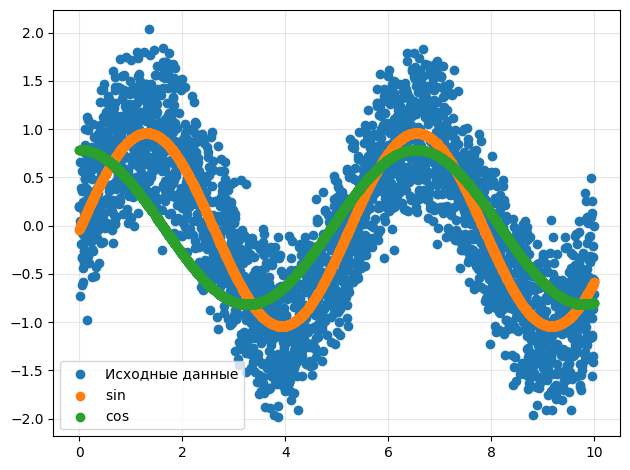

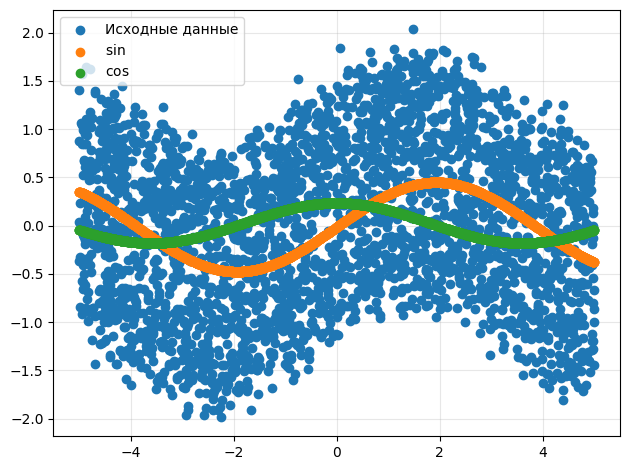

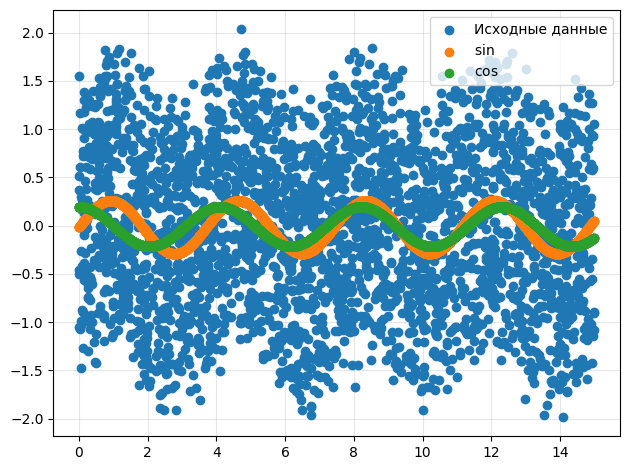

In [9]:
for p in df_shift.iloc:
	col = p.name
	
	sin_shift = p["R2 sin shift"]
	cos_shift = p["R2 cos shift"]
	
	x_sin = np.column_stack([np.sin(x[col] * sin_shift)])
	x_cos = np.column_stack([np.cos(x[col] * cos_shift)])

	sin_model, cos_model = LinearRegression().fit(x_sin, y), LinearRegression().fit(x_cos, y)

	f_sin = sin_model.coef_[0] * x_sin[:, 0] + sin_model.intercept_
	f_cos = cos_model.coef_[0] * x_cos[:, 0] + cos_model.intercept_

	plt.scatter(x[col], y, label="Исходные данные", zorder=3)
	plt.scatter(x[col], f_sin, label=r"$\sin$", zorder=4)
	plt.scatter(x[col], f_cos, label=r"$\cos$", zorder=4)

	plt.legend()
	plt.grid(alpha=.3)

	plt.tight_layout()
	plt.show()

In [18]:
mask = {
	"ridge__solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"],
	"ridge__alpha": uniform(loc=0, scale=4).rvs(10)
}

scoring = {
	"r2": make_scorer(r2_score),
	"neg_mean_squared_error": make_scorer(mean_squared_error),
	"neg_mean_absolute_error": make_scorer(mean_absolute_error),
}

pipeline = make_pipeline(
	StandardScaler(),
	Ridge()
)

model = GridSearchCV(
	pipeline,
	mask,
	scoring=scoring,
	refit="r2",
	error_score="raise"
).fit(x["p1"].to_frame(), y)

print(model.best_params_)
print(model.best_score_)
print(model.best_estimator_.steps)

for shift in shifts:
	print(shift)

{'ridge__alpha': np.float64(2.4286931374106384), 'ridge__solver': 'saga'}
0.12322341865925132
[('standardscaler', StandardScaler()), ('ridge', Ridge(alpha=np.float64(2.4286931374106384), solver='saga'))]
1.1786267253756029
-1.0835671178561448
0.878867554055889
-1.682046814060755
0.07423057015578549
-1.101472938484787
-1.8949902313045457
-0.06288933588178347
-0.38365106159924967
-1.09880655818995
1.8207543604616345
-0.6259849340213945
0.19015883195373928
-1.5697194137266979
-0.1004150429105155
0.034692496032041165
-1.1094632525027928
0.04930352257928505
-1.9267745568969437
-0.6028999050766186
1.508896456617429
-1.547923252933685
0.4559442145518824
-1.3969783861064158
0.7112339585837135
0.7426851824680523
1.5300324028150676
1.2184353631535207
1.8062860988139178
0.7611615331332822
0.74014827760578
1.2105160584930335
0.22412427562294002
1.954706346102759
1.8708245561929593
-1.3892456302177925
-0.5731219329723891
-0.8491625850852262
1.5091857462634677
0.6169452042205206
-0.6030778456235044
